In [ ]:
import numpy as np
import quant_rotor.core.dense.de_solve as de
from quant_rotor.core.dense.t_amplitudes_periodic_unique import unique_residuals
from quant_rotor.core.dense.t_amplitudes_periodic import t_periodic
import matplotlib.pyplot as plt 
from quant_rotor.core.dense.hamiltonian_big import hamiltonian_general, hamiltonian_big
from quant_rotor.core.dense.hamiltonian import hamiltonian
from scipy.sparse.linalg import eigsh
import os
from quant_rotor.models.dense.t_amplitudes_guess import t_1_amplitude_guess_ground_state, t_2_amplitude_guess_ground_state
from scipy.signal import find_peaks

# Time propagation.

## Check the unique residuals.

In [2]:
g = 0.1

residuals_unique = unique_residuals(5, 5, g)
single_unique = residuals_unique[0]
double_unique = residuals_unique[1]
energy_unique = residuals_unique[2]

residuals = t_periodic(5, 5, g)
single = residuals[0]
double = residuals[1]
energy = residuals[2]

In [3]:
single_unique == single

array([[[False],
        [False],
        [ True],
        [ True]],

       [[False],
        [False],
        [ True],
        [ True]],

       [[False],
        [False],
        [ True],
        [ True]],

       [[False],
        [False],
        [ True],
        [ True]],

       [[False],
        [False],
        [ True],
        [ True]]])

In [4]:
double_unique.flatten().shape

(400,)

In [5]:
energy == energy_unique

np.True_

## Test the DE solver with residual input.

In [6]:
states = 7
sites = 3
g = 0.1

H_K_V_3 = hamiltonian(states, sites, g)
eig_val_3, eig_vec_3 = np.linalg.eig(H_K_V_3[0])
index = np.argmin(eig_val_3)
eig_val_3[index]

np.complex128(-0.020101729045148495-4.459304180178529e-30j)

In [7]:
t_1 = t_1_amplitude_guess_ground_state(states, sites, g, eig_vec_3, eig_val_3)
t_2 = t_2_amplitude_guess_ground_state(states, sites, g, eig_vec_3, eig_val_3)
one_max = t_1.flat[np.argmax(np.abs(t_1))]
two_max = t_2.flat[np.argmax(np.abs(t_2))]
print(f"T_1 max: {one_max}")
print(f"T_2 max: {two_max}")

T_1 max: (-0.0011068207361258709-9.681654868765796e-35j)
T_2 max: (-0.0394014771866021-4.8255691467660705e-55j)


In [8]:
sites = 3
states = 7

g-val: 0.1
TDCC Ground State: (0.018943300667335485+0.027394419735915533j)
ED Ground State: (-0.020101729045148495-4.459304180178529e-30j)
Diff Ground State: 0.013204469669814332

g-val: 0.2
TDCC Ground State: (0.019742391092472077+0.0022847687187345657j)
ED Ground State: (-0.08587361259502421-1.1555579671358981e-32j)
Diff Ground State: 0.06599945414375316

g-val: 0.3
TDCC Ground State: (-0.20448891329550128+0.13476514154506192j)
ED Ground State: (-0.20438284489138692-5.9164567891575885e-31j)
Diff Ground State: 0.040519909352895955

g-val: 0.4
TDCC Ground State: (-0.40204057700289214+0.6986678330300985j)
ED Ground State: (-0.3785544605354991-3.7594152514438844e-31j)
Diff Ground State: 0.4275307498906642

g-val: 0.5
TDCC Ground State: (-0.5472993059325879+1.574715304326091j)
ED Ground State: (-0.6052475136691362-7.395570986446986e-32j)
Diff Ground State: 1.0618652059611549

g-val: 0.6
TDCC Ground State: (-0.3695962649678175+1.802702736590476j)
ED Ground State: (-0.8766985396749771-1.601

/Users/gilfrim/Desktop/Projects/Computational_Analisis_of_Many_Rotor_Systems/.venv/lib/python3.13/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/gilfrim/Desktop/Projects/Computational_Analisis_of_Many_Rotor_Systems/.venv/lib/python3.13/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


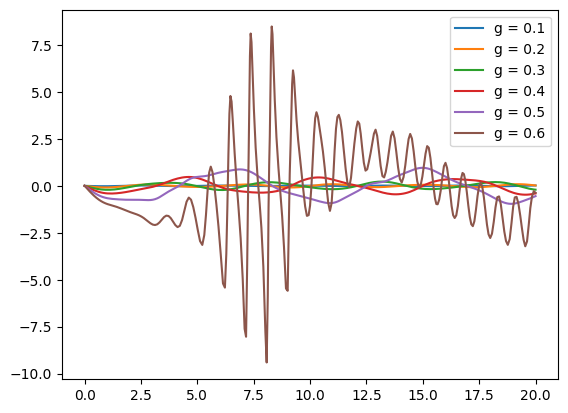

g-val: 0.1
TDCC T_1 max: (-0.002002219074177556+0.0009699941932397444j)
ED T_1 max: (-0.0011068207361258709-9.681654868765796e-35j)
Diff T_1: 0.0011179871108396265

g-val: 0.2
TDCC T_1 max: (-3.3740111925861685e-05+0.002836028314279044j)
ED T_1 max: (-0.0051067135688499495+1.5789200010065044e-33j)
Diff T_1: 0.002270484559311896

g-val: 0.3
TDCC T_1 max: (0.0010095629628108843-0.01579103183225651j)
ED T_1 max: (-0.01283765977862741-1.0561122784233638e-31j)
Diff T_1: 0.0029856111759893333

g-val: 0.4
TDCC T_1 max: (-0.045432127450891535-0.0188342752345292j)
ED T_1 max: (-0.02454227835893036+0j)
Diff T_1: 0.02463910153553836

g-val: 0.5
TDCC T_1 max: (-0.08313403966378799-0.00841135783589098j)
ED T_1 max: (-0.03966671935746545-5.536952281810672e-33j)
Diff T_1: 0.043891760113284134

g-val: 0.6
TDCC T_1 max: (0.1294034899487256-0.2901183800204864j)
ED T_1 max: (-0.057138093995859215+1.1893251661498147e-32j)
Diff T_1: 0.26053144756678615



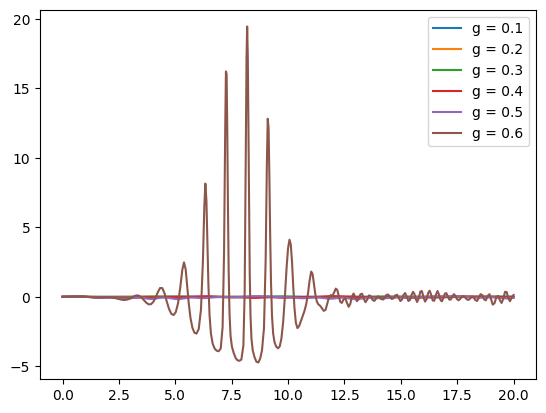

g-val: 0.1
TDCC T_2 max: (-0.054344444188547926+0.03684817055856742j)
ED T_2 max: (-0.0394014771866021-4.8255691467660705e-55j)
Diff T_2: 0.026257538094435096

g-val: 0.2
TDCC T_2 max: (-0.0022246348232412396+0.01919225082305004j)
ED T_2 max: (-0.0825049109904765+5.96045137134208e-54j)
Diff T_2: 0.06318415811302261

g-val: 0.3
TDCC T_2 max: (-0.08902442935527904-0.12966412326897556j)
ED T_2 max: (-0.12850136241687846-3.733234100473286e-31j)
Diff T_2: 0.028782247298645175

g-val: 0.4
TDCC T_2 max: (-0.3323602248698438-0.1713391414281362j)
ED T_2 max: (-0.17561272679722148-1.1056701941830879e-31j)
Diff T_2: 0.19831296162343784

g-val: 0.5
TDCC T_2 max: (-0.5615837890015627-0.15306446424907977j)
ED T_2 max: (-0.22158033208981717-7.382603042420274e-32j)
Diff T_2: 0.3604893220626816

g-val: 0.6
TDCC T_2 max: (3.3489200060682474+5.60468926932817j)
ED T_2 max: (-0.2645440143491685+1.0703926495348333e-31j)
Diff T_2: 6.264453382860183



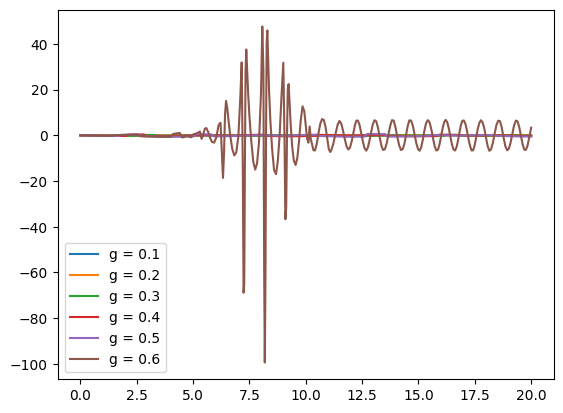

In [18]:
# t_0_array = np.zeros((9, 203), dtype=complex)
# time_array = np.zeros((9, 203), dtype=complex)
# t_1_max_array = np.zeros((9, 269), dtype=complex)
# t_2_max_array = np.zeros((9, 269), dtype=complex)

t_0_array = []
time_array = []
t_1_max_array = []
t_2_max_array = []
t_1_ED = np.zeros((9), dtype=complex)
t_2_ED = np.zeros((9), dtype=complex)
ground_state_ED = np.zeros((9), dtype=complex)
tf = 20

ran1 = 0
ran2 = 6

for i in range(ran1, ran2):
    g = (i+1) /10

    time,t_0, t1_max, t2_max, _, _ = de.integration_scheme(sites, states, g, t_init=0,t_final=tf,nof_points=10000)

    H_K_V_3 = hamiltonian(states, sites, g)
    eig_val_3, eig_vec_3 = np.linalg.eig(H_K_V_3[0])
    index = np.argmin(eig_val_3)

    t_1 = t_1_amplitude_guess_ground_state(states, sites, g, eig_vec_3, eig_val_3)
    t_2 = t_2_amplitude_guess_ground_state(states, sites, g, eig_vec_3, eig_val_3)
    one_max = t_1.flat[np.argmax(np.abs(t_1))]
    two_max = t_2.flat[np.argmax(np.abs(t_2))]
    
    # t_0_array[i, :] = t_0
    # time_array[i, :] = time
    # t_1_max_array[i, :] = t1_max
    # t_2_max_array[i, :] = t2_max
    t_1_ED[i] = one_max
    t_2_ED[i] = two_max
    ground_state_ED[i] = eig_val_3[index]

    t_0_array.append(t_0)
    time_array.append(time)
    t_1_max_array.append(t1_max)
    t_2_max_array.append(t2_max)

# t_0_array = np.array(t_0_array)
# time_array = np.array(time_array)
# t_1_max_array = np.array(t_1_max_array)
# t_2_max_array = np.array(t_2_max_array)

for i in range(ran1, ran2):
    g = (i+1) /10
    print(f"g-val: {g}")

    plt.plot(time_array[i], t_0_array[i], label=f"g = {g}")

    print(f"TDCC Ground State: {t_0_array[i][-1]}")
    print(f"ED Ground State: {ground_state_ED[i]}")
    print(f"Diff Ground State: {abs(abs(t_0_array[i][-1]) - abs(ground_state_ED[i].real))}\n")

plt.legend()
plt.show()


for i in range(ran1, ran2):
    g = (i+1) /10
    print(f"g-val: {g}")

    plt.plot(time_array[i], t_1_max_array[i], label=f"g = {g}")

    print(f"TDCC T_1 max: {t_1_max_array[i][-1]}")
    print(f"ED T_1 max: {t_1_ED[i]}")
    print(f"Diff T_1: {abs(abs(t_1_max_array[i][-1]) - abs(t_1_ED[i].real))}\n")

plt.legend()
plt.show()

for i in range(ran1, ran2):
    g = (i+1) /10
    print(f"g-val: {g}")

    plt.plot(time_array[i], t_2_max_array[i], label=f"g = {g}")

    print(f"TDCC T_2 max: {t_2_max_array[i][-1]}")
    print(f"ED T_2 max: {t_2_ED[i]}")
    print(f"Diff T_2: {abs(abs(t_2_max_array[i][-1]) - abs(t_2_ED[i].real))}\n")

plt.legend()
plt.show()

In [10]:
t_0_array[i, :] = t_0

TypeError: list indices must be integers or slices, not tuple

In [ ]:
states = 7
sites = 3
g = 0.6
a = states - 1
i = 1

In [ ]:
time,t_0, one_max_TDCC, two_max_TDCC, dTa_idt_sol, dTab_ijdt_sol = de.integration_scheme(sites, states, g, t_init=0,t_final=tf,nof_points=10000)

In [ ]:
t_a_i_tensor = np.full((sites, a, i), 0, dtype=complex)
t_ab_ij_tensor = np.full((sites, sites, a, a, i, i), 0, dtype=complex)

dTab_ijdt = dTab_ijdt_sol.reshape(sites, a, a, i, i)
dTa_idt = dTa_idt_sol.reshape(a, i)

t_a_i_tensor[0] = dTa_idt

for site_1 in range(1, sites):
    t_a_i_tensor[site_1] = t_a_i_tensor[0]
    t_ab_ij_tensor[0, site_1] = dTab_ijdt[site_1]
    for site_2 in range(1, sites):
        t_ab_ij_tensor[site_2, (site_1 + site_2) % sites] = t_ab_ij_tensor[0, site_1]

In [ ]:
one_max, two_max, energy, t_1, t_2 = t_periodic(sites, states, g, t_a_i_tensor_initial=t_a_i_tensor, t_ab_ij_tensor_initial=t_ab_ij_tensor)

In [ ]:
print(f"{one_max_TDCC=}")
print(f"{one_max=}")
print(f"{one_max_TDCC=}")
print(f"{two_max=}")
print(f"{t_0[-1]=} ")
print(f"{energy=}")

one_max_TDCC=np.complex128(-0.12574057152254292+0j)
one_max=np.complex128(4.314741897104568e-10+0j)
one_max_TDCC=np.complex128(-0.12574057152254292+0j)
two_max=np.complex128(-9.79180149462966e-09+0j)
t_0[-1]=np.complex128(2.2302319378514817-0j) 
energy=np.complex128(-2.23094551614323+0j)


In [ ]:
np.array_equal(t_a_i_tensor, t_1)

True

In [ ]:
np.array_equal(t_2, t_ab_ij_tensor)

True

In [11]:
states = 7
sites = 3
g=0.6

In [12]:
# Your simulation outputs
time, t_0, one_max_TDCC, two_max_TDCC, dTa_idt_sol, dTab_ijdt_sol = de.integration_scheme(
    sites, states, g, t_init=0, t_final=150, nof_points=100000
)

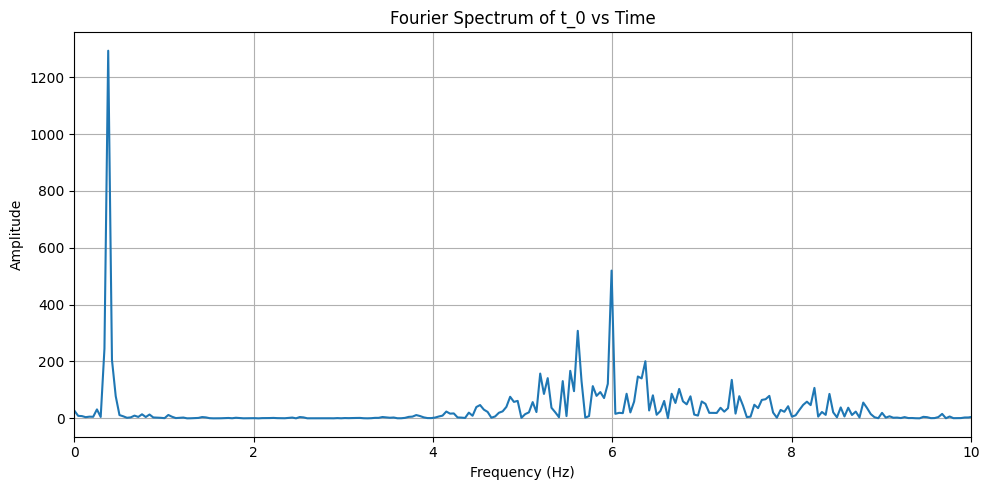

Dominant Frequencies: [0.376991118]


In [16]:

# Ensure t_0 is real or extract real part
t_0_real = np.real(t_0)
y = 1*np.exp(1j*4.5*time) + 0.5*np.exp(1j*2*time) 

# Time step (assumes uniform sampling)
N = len(time)
dt = time[-1]/N

# FFT
fft_vals = np.fft.fftshift(np.fft.fft(t_0_real))
freqs = np.fft.fftshift(np.fft.fftfreq(N, dt))* 2*np.pi

# Take positive half
positive_freqs = freqs[N//2:]
fft_magnitude = np.abs(fft_vals[N//2:])**2/N

# Plot FFT spectrum
plt.figure(figsize=(10, 5))
plt.plot(positive_freqs, fft_magnitude)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.title("Fourier Spectrum of t_0 vs Time")
plt.xlim(0,10)
plt.grid(True)
plt.tight_layout()
plt.show()

# Identify top peaks

peaks, _ = find_peaks(fft_magnitude, height=np.max(fft_magnitude))  # threshold as 10% of max
dominant_freqs = positive_freqs[peaks]
print("Dominant Frequencies:", dominant_freqs)

Dominant Frequencies: [1.801179788]
Ground state: (-0.020101729045148495-4.459304180178529e-30j)


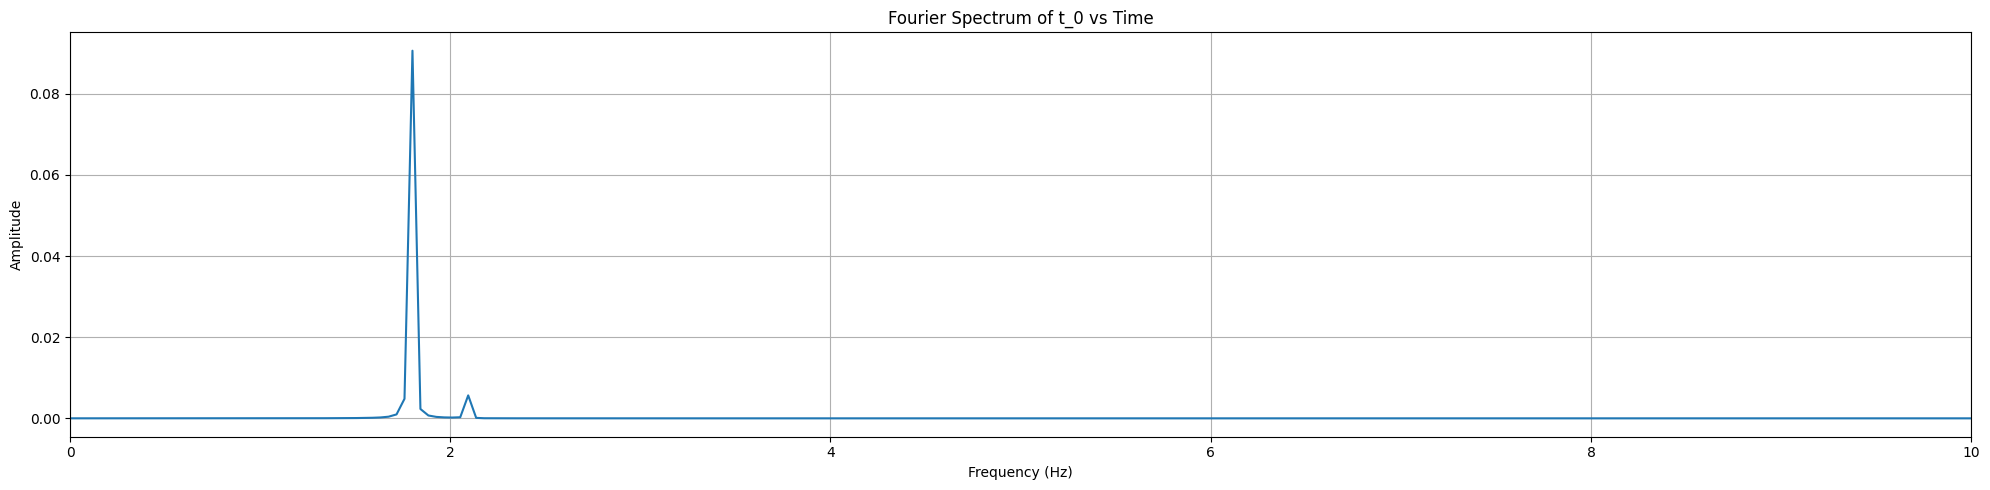

Dominant Frequencies: [1.549852376]
Ground state: (-0.08587361259502421-1.1555579671358981e-32j)


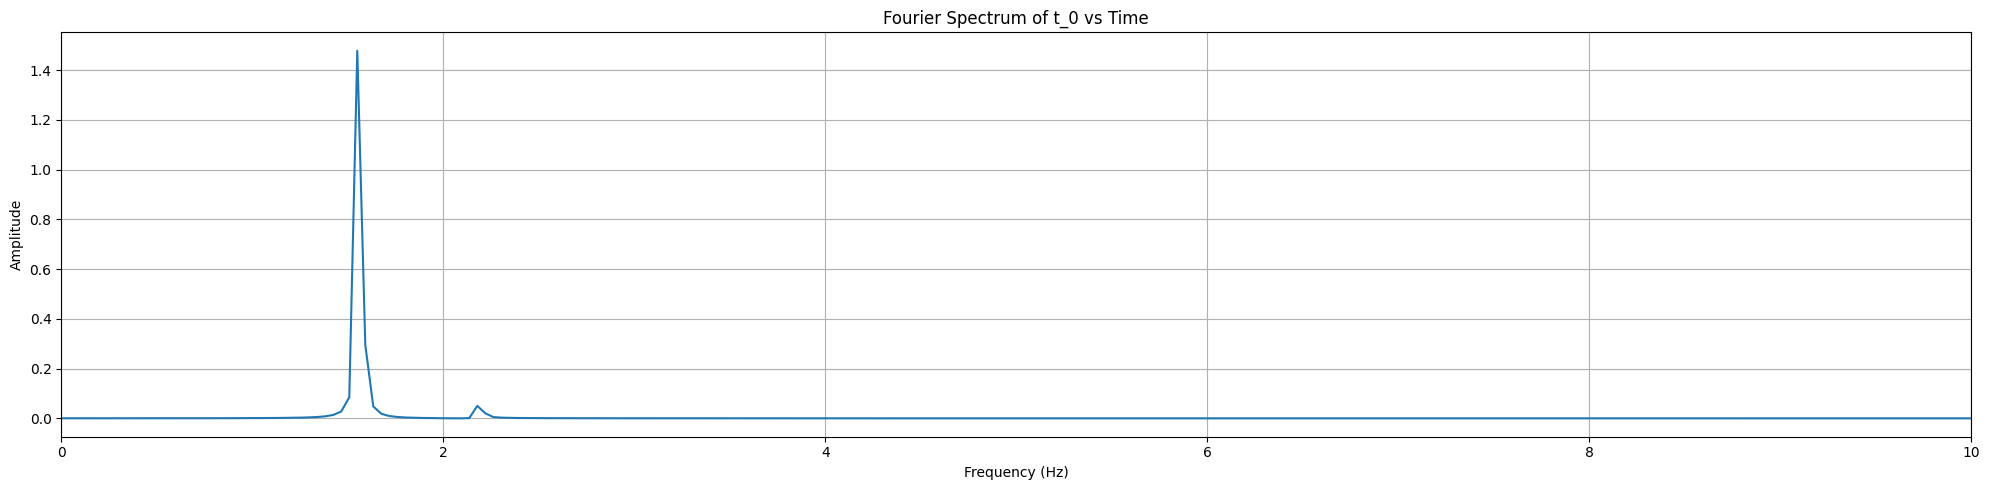

Dominant Frequencies: [1.298524963]
Ground state: (-0.20438284489138692-5.9164567891575885e-31j)


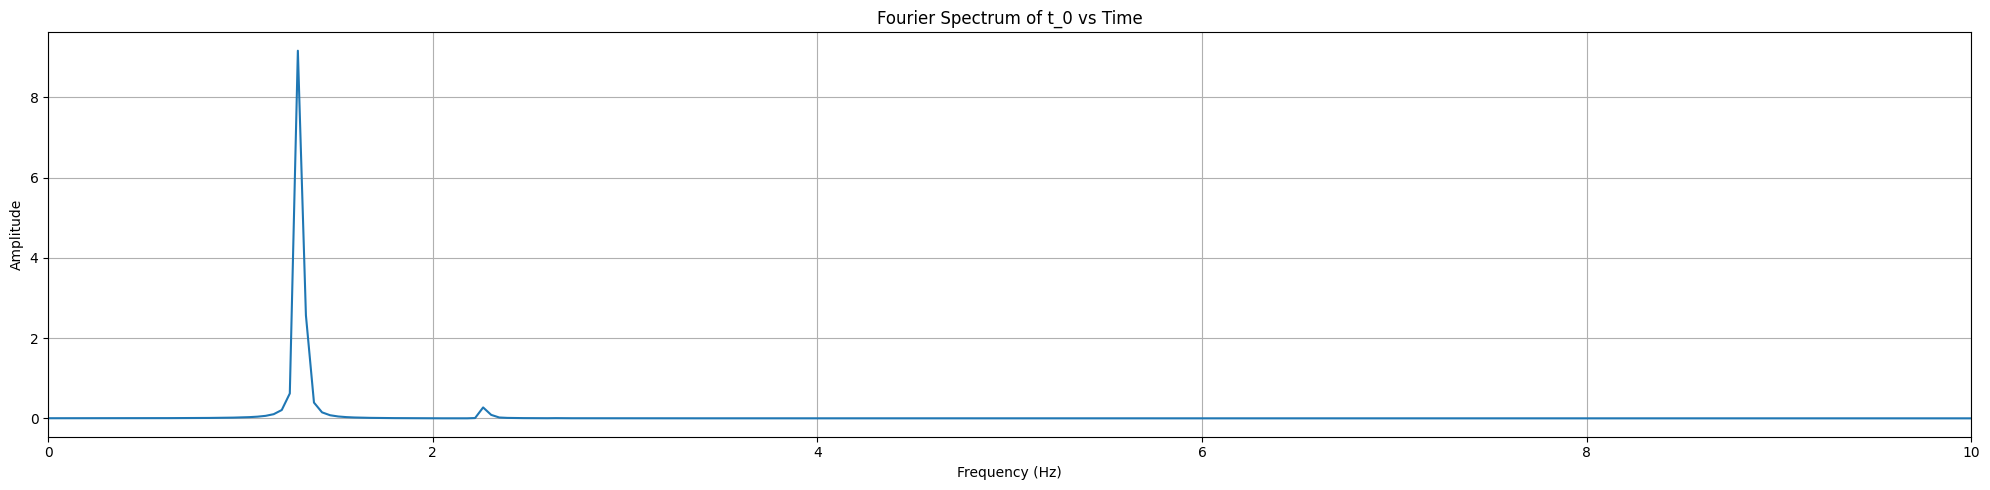

Dominant Frequencies: [1.047197551]
Ground state: (-0.3785544605354991-3.7594152514438844e-31j)


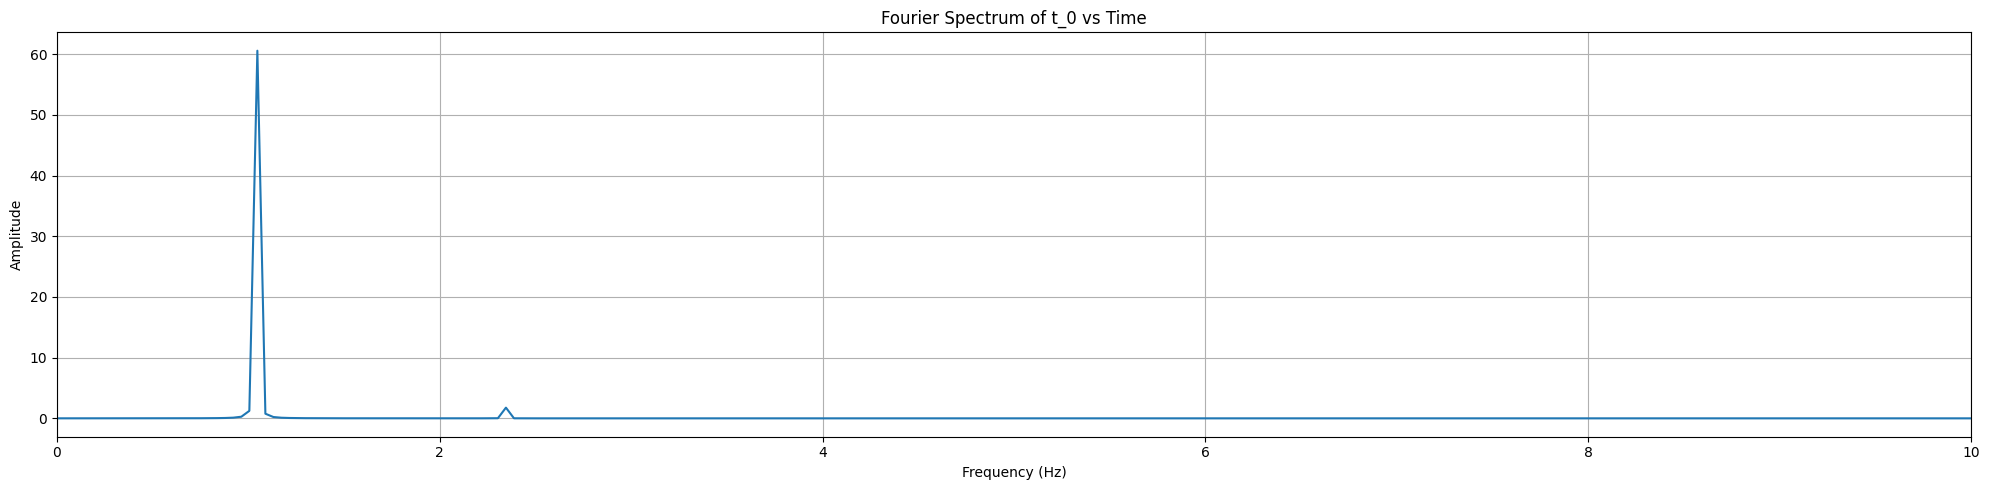

Dominant Frequencies: [0.753982237]
Ground state: (-0.6052475136691362-7.395570986446986e-32j)


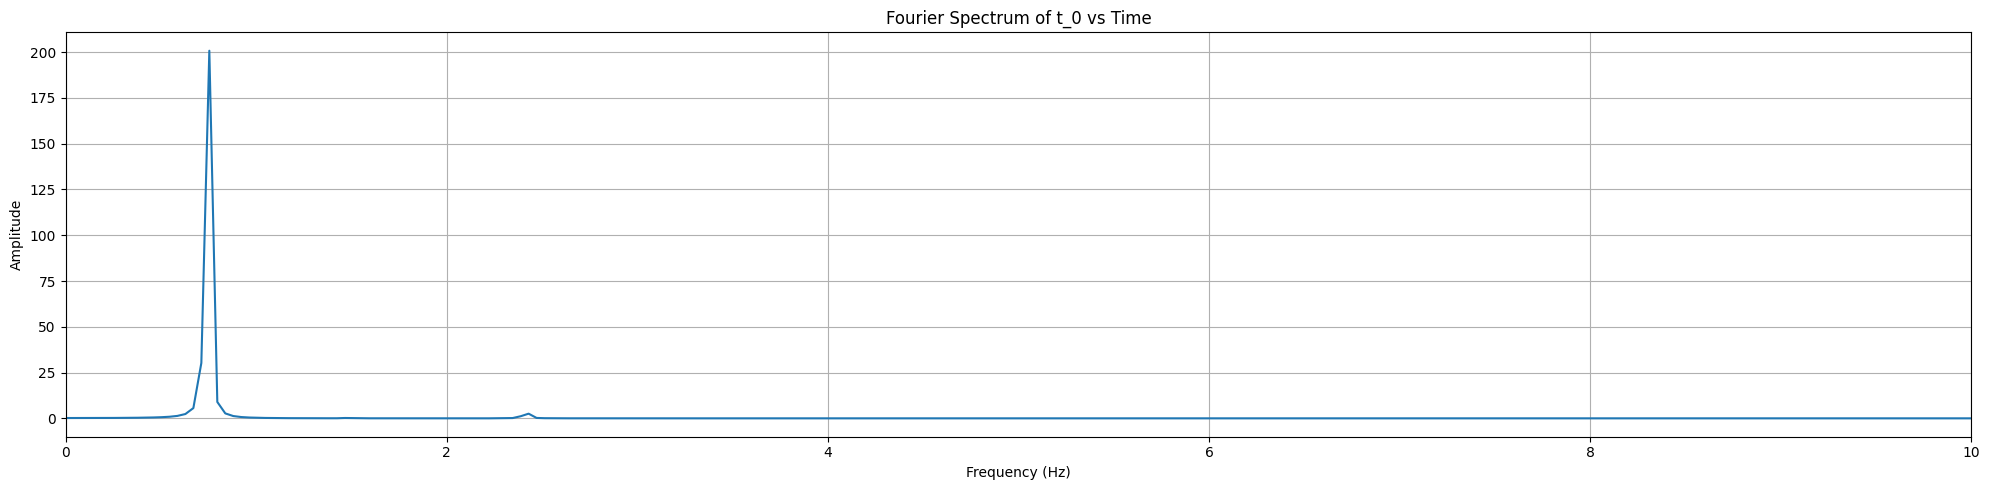

Dominant Frequencies: [0.376991118 5.989969993]
Ground state: (-0.8766985396749771-1.6016514900023803e-31j)


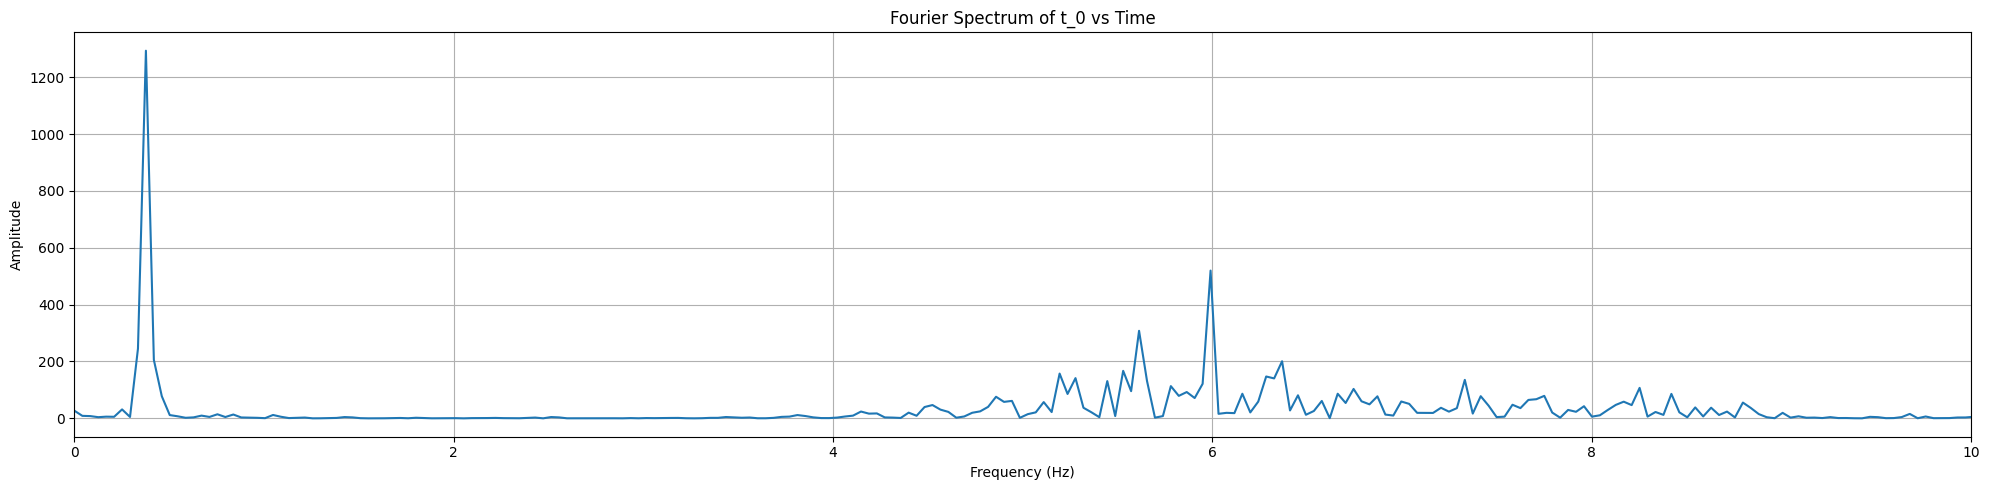

In [22]:
ran1 = 0
ran2 = 6
states = 7
sites = 3

for i in range(ran1, ran2):
    g = (i+1) /10

    time, t_0, one_max_TDCC, two_max_TDCC, dTa_idt_sol, dTab_ijdt_sol = de.integration_scheme(sites, states, g, t_init=0, t_final=150, nof_points=100000)

    H_K_V_3 = hamiltonian(states, sites, g)
    eig_val_3, eig_vec_3 = np.linalg.eig(H_K_V_3[0])
    index = np.argmin(eig_val_3)

    # Ensure t_0 is real or extract real part
    t_0_real = np.real(t_0)
    y = 1*np.exp(1j*4.5*time) + 0.5*np.exp(1j*2*time) 

    # Time step (assumes uniform sampling)
    N = len(time)
    dt = time[-1]/N

    # FFT
    fft_vals = np.fft.fftshift(np.fft.fft(t_0_real))
    freqs = np.fft.fftshift(np.fft.fftfreq(N, dt))* 2*np.pi

    # Take positive half
    positive_freqs = freqs[N//2:]
    fft_magnitude = np.abs(fft_vals[N//2:])**2/N

    peaks, _ = find_peaks(fft_magnitude, height=0.4 * np.max(fft_magnitude))  # threshold as 10% of max
    dominant_freqs = positive_freqs[peaks]
    print("Dominant Frequencies:", dominant_freqs)
    print("Ground state:", eig_val_3[index])
    plt.figure(figsize=(20, 5))
    plt.plot(positive_freqs, fft_magnitude)

    # Plot FFT spectrum

    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Amplitude")
    plt.title("Fourier Spectrum of t_0 vs Time")
    plt.xlim(0,10)
    plt.grid(True)
    plt.tight_layout()
    plt.show()